In [2]:
import tkinter as tk
from tkinter import ttk
from tkinter.filedialog import askopenfilename
import sv_ttk #dark ttk theme

import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from PIL import ImageTk, Image
import seaborn as sns
import numpy as np
import os

# Useful helper functions

In [3]:
#chatgpt generated
def import_file(filename):
    """
    Imports a file and stores its data in a structured format.
    Supports CSV, Excel, JSON, and text files.
    Returns a Pandas DataFrame if possible; otherwise, returns raw text or structured data.
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File '{filename}' not found.")

    file_extension = os.path.splitext(filename)[-1].lower()

    try:
        if file_extension in ['.csv']:
            return pd.read_csv(filename)
        elif file_extension in ['.xlsx', '.xls']:
            return pd.read_excel(filename)
        elif file_extension in ['.json']:
            with open(filename, 'r', encoding='utf-8') as f:
                data = json.load(f)
                return pd.json_normalize(data) if isinstance(data, list) else data
        elif file_extension in ['.txt']:
            with open(filename, 'r', encoding='utf-8') as f:
                return f.read()
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")
    except Exception as e:
        raise RuntimeError(f"Error processing file '{filename}': {str(e)}")

# Main app

In [3]:
#the image part
class DataVisualizer(ttk.Frame):
    def __init__(self, parent, data_class):
        super().__init__(parent)
        self.data_class = data_class
        
        self.display_panel = ttk.Label(self)
        self.display_panel.pack(fill='both', expand=True, padx=10)

    def update(self, mode='', x_vals=[], y_vals=[]):
        """
        Given a given mode, update the graph data and set the display window to reflect this change in graph
        """
        if mode == 'corr_mat':
            corr = self.data_class.loaded_data.corr()
            sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values).get_figure().savefig("temp.png")

            img = Image.open('temp.png')
            img = img.resize((400, 400), Image.ANTIALIAS)
            self.imgtk = ImageTk.PhotoImage(img)
            self.display_panel.config(image=self.imgtk)
        elif mode == 'scatter':
            pass
        elif mode == 'hist':
            pass
        elif mode == 'bwp':
            pass

In [16]:
#basic analysis and summary of imported data
class DataPreview(ttk.Frame):
    def __init__(self, parent):
        super().__init__(parent)

        self.data_label = ttk.Label(self, text='No data loaded')
        self.data_label.config(width=200, font=("Courier", 7))
        self.scrollbar = ttk.Scrollbar(self, orient='vertical')

        self.scrollbar.pack()
        self.data_label.pack(side='top', fill='both', expand=True, padx=10)
        self.data_label.configure(yscrollcommand=self.scrollbar.set)

    def update(self, df):
        new_text = ''
        for col in df.columns:
            new_text += f'Column: {col}\n'
            if is_numeric_dtype(df[col]):
                #calculate some numeric stats
                new_text += f' - Avg: {round(df[col].mean(), 2)}\n'
                new_text += f' - Min: {df[col].min()}, Max: {df[col].max()}\n'
            else:
                new_text += f' - Unique values: {" ".join(set([v for v in df[col]]))}\n'
                
        self.data_label.config(text=new_text)

In [13]:
#all the buttons to make stuff happen
class SelectionPanel(ttk.Frame):
    def __init__(self, parent, data_visualizer):
        super().__init__(parent)
        self.data_visualizer = data_visualizer

        left_side = ttk.Frame(self)
        right_side = ttk.Frame(self)

        #left side items
        mode_options = ['Graph', 'Correlation Matrix']
        self.mode_option = tk.StringVar(self)
        self.mode_dropdown = ttk.OptionMenu(
            left_side,
            self.mode_option,
            'Select Mode',
            *mode_options,
            command=self.options_changed
        )

        graph_options = ['Scatter', 'Histogram', 'BW Plot']
        self.graph_option = tk.StringVar(self)
        self.graph_dropdown = ttk.OptionMenu(
            left_side,
            self.graph_option,
            'Select Graph',
            *graph_options,
            command=self.options_changed
        )

        anal_options = ['K-Means', 'Classification', 'Regression']
        self.anal_option = tk.StringVar(self)
        self.anal_dropdown = ttk.OptionMenu(
            left_side,
            self.anal_option,
            'Analysis Mode',
            *anal_options,
            command=self.options_changed
        )

        #right side_items
        

        left_side.pack(side='left', fill='both', expand=True)
        right_side.pack(side='right', fill='both', expand=True)
        

    def options_changed(self, *args):
        self.update_visibility()
    
    def reset_visibility(self):
        """
        Unpacks all items from frame to reset the structure of the UI
        """
        self.mode_dropdown.pack_forget()
        self.graph_dropdown.pack_forget()
        self.anal_dropdown.pack_forget()
    
    def update_visibility(self):
        """
        Determines what items will be visible
        """
        self.reset_visibility()

        self.mode_dropdown.pack(side='top', fill='both', expand=True, pady=3)
        if self.mode_option.get() == 'Correlation Matrix':
            self.data_visualizer.update('corr_mat')
        elif self.mode_option.get() == 'Graph':
            #add the new dropdowns to the menu visible when on Graph mode
            self.graph_dropdown.pack(side='top', fill='both', expand=True, pady=3)
            self.anal_dropdown.pack(side='top', fill='both', expand=True, pady=3)
            
            self.data_visualizer.update('')

In [14]:
#main app structure and functions
class App(ttk.Frame):
    def __init__(self, parent):
        super().__init__(parent)

        top_layer = ttk.Frame(self)
        self.import_btn = ttk.Button(top_layer, text="Import data", command=self.select_file)

        middle_layer = ttk.Frame(self)
        self.data_preview = DataPreview(middle_layer)
        self.data_visualizer = DataVisualizer(middle_layer, self)
        self.selection_panel = SelectionPanel(middle_layer, self.data_visualizer)

        bottom_layer = ttk.Frame(self)
        self.status_text = ttk.Label(bottom_layer, text="")
        
        #top layer
        self.import_btn.pack(side='left', padx=10, pady=10)
        top_layer.pack(side='top', fill='both')

        #middle layer
        self.data_preview.pack(side='left', padx=5, pady=5)
        self.selection_panel.pack(side='left', padx=5, pady=5)
        self.data_visualizer.pack(side='right', padx=5, pady=5)
        middle_layer.pack(fill='both', expand=True)

        #bottom layer
        self.status_text.pack(side='left', padx=10, pady=10)
        bottom_layer.pack(side='bottom', fill='both')

        self.loaded_data = None

    def select_file(self):
        """
        Uses tkinter to open a file exploration panel to allow the user to select a file.
        Uses the import_file function to load the file into a PD object.
        Runs some basic data cleaning on loaded data
        """
        filename = askopenfilename() # get file location using tkinter
        try:
            self.loaded_data = import_file(filename)
            self.loaded_data = self.loaded_data.fillna(0)
            self.status_text.config(text='Data loaded!', foreground='green')
            self.selection_panel.update_visibility()

            #display some basic analysis features
            self.data_preview.update(self.loaded_data)
        except Exception as e:
            print(e)
            self.status_text.config(text="Can't open file", foreground='red')

In [17]:
root = tk.Tk()
root.title('Data analysis program')
root.geometry("1020x500")

App(root).pack(side="top", fill="both", expand=True)
sv_ttk.set_theme("dark") #make the app evil (dark theme)
root.mainloop()

TclError: unknown option "-yscrollcommand"

In [4]:
df = import_file('consumer_purchasing_patterns.csv')
df.head()

,transaction_id,customer_id,product_id,product_name,category,transaction_date,day_of_week,time_of_day,quantity,unit_price,...,customer_satisfaction,days_since_last_purchase,was_returned,age_group,gender,income_bracket,location,membership_level,account_age_days,total_price
0,TXN000001-1,7a80a8f1,TOY004,Toys Item 4,Toys,2024-02-13,Tuesday,17:58,2,34.65,...,1,145,False,18-24,Non-binary,25K-50K,Suburban,Silver,54,69.30
1,TXN000001-2,7a80a8f1,SPO008,Sports Item 8,Sports,2024-02-13,Tuesday,20:54,1,87.39,...,4,149,True,18-24,Non-binary,25K-50K,Suburban,Silver,54,87.39
2,TXN000002-3,bde863b7,BEA008,Beauty Item 8,Beauty,2024-01-23,Tuesday,18:45,2,43.55,...,2,179,False,35-44,Female,100K+,Rural,Silver,1229,87.10
3,TXN000002-4,bde863b7,TOY001,Toys Item 1,Toys,2024-01-23,Tuesday,14:35,2,28.61,...,2,44,False,35-44,Female,100K+,Rural,Silver,1229,57.22
4,TXN000002-5,bde863b7,ELE007,Electronics Item 7,Electronics,2024-01-23,Tuesday,12:08,1,699.61,...,4,73,False,35-44,Female,100K+,Rural,Silver,1229,699.61


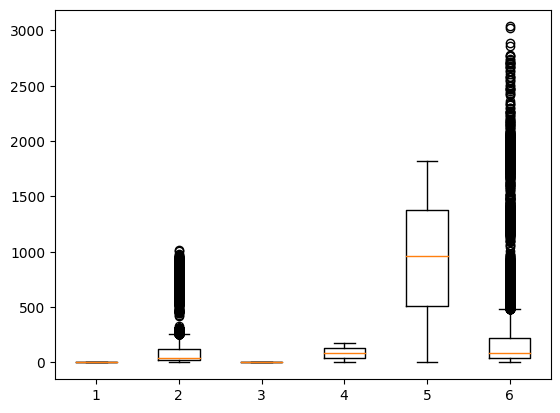

In [27]:
data = [list(df[col]) for col in df.columns if is_numeric_dtype(df[col])]
data.pop(4)
plt.boxplot(data)
plt.show()

In [20]:
data[4]

[False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 Fa